# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

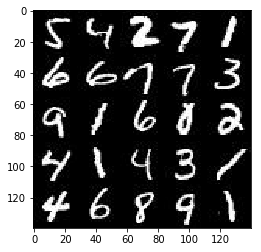

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

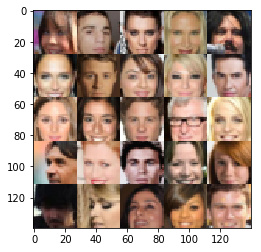

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/home/ww/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_image = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name ="input_real")
    z_data = tf.placeholder(tf.float32, shape=(None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return real_image, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope("discriminator", reuse=reuse):
        dis_conv1 = tf.layers.conv2d(images, 32, 5, strides=2, padding='same')
        dis_conv1 = tf.maximum(alpha*dis_conv1, dis_conv1)
        # 14x14x32
        dis_conv2 = tf.layers.conv2d(dis_conv1, 64, 5, strides=2, padding='same')
        dis_conv2 = tf.layers.batch_normalization(dis_conv2, training=True)
        dis_conv2 = tf.maximum(alpha*dis_conv2, dis_conv2)
        # 7x7x64
        
        dis_conv3 = tf.layers.conv2d(dis_conv2, 128, 5, strides=1, padding='same')
        dis_conv3 = tf.layers.batch_normalization(dis_conv3, training=True)
        dis_conv3 = tf.maximum(alpha*dis_conv3, dis_conv3)
        #7x7x128
        
        flat = tf.reshape(dis_conv3, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.nn.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope("generator", reuse=not is_train):
        de_full1 = tf.layers.dense(z, 7*7*128)
        de_full1 = tf.reshape(de_full1, (-1, 7, 7, 128))
        de_full1 = tf.layers.batch_normalization(de_full1, training=is_train)
        de_full1 = tf.maximum(alpha*de_full1, de_full1)
        #7x7x128
        
        de_conv1 = tf.layers.conv2d_transpose(de_full1, 64, 5, strides=2,padding='same')
        de_conv1 = tf.layers.batch_normalization(de_conv1, training=is_train)
        de_conv1 = tf.maximum(alpha*de_conv1, de_conv1)
        #14x14x64
        
        de_conv2 = tf.layers.conv2d_transpose(de_conv1, 32, 5, strides=2, padding='same')
        de_conv2 = tf.layers.batch_normalization(de_conv2, training=is_train)
        de_conv2 = tf.maximum(alpha*de_conv2, de_conv2)
        #28*28*32
        
        logits = tf.layers.conv2d_transpose(de_conv2, out_channel_dim, 5, strides=1, padding='same')
        #28x28x3
        out = tf.tanh(logits)
        
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real,  reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits= d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real+d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    tvars = tf.trainable_variables()
    d_vars = [var for var in tvars if var.name.startswith('discriminator')]
    g_vars = [var for var in tvars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
   
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #tf.reset_default_graph()
    #print("data_shape", type(data_shape), data_shape)
    
    image_width=data_shape[1]
    image_height=data_shape[2]
    image_channels = data_shape[3]
    print("image_width:", image_width, "image_height:",image_height, 
          "image_channels:",image_channels, "data_num:",data_shape[0], "batch_num: ", data_shape[0]//batch_size)
    input_real, input_z, learningrate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learningrate, beta1)
    
    steps = 0
    print_every= 25
    show_every =  100
    losses = []
    saver = tf.train.Saver()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images *= 2
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real:batch_images, input_z:batch_z,learningrate:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z:batch_z, learningrate:learning_rate})
                
                if steps % print_every ==0:
                    train_loss_d = sess.run(d_loss, feed_dict={input_real:batch_images, input_z:batch_z})
                    train_loss_g = sess.run(g_loss, feed_dict={input_z:batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count), 
                          "Batch num {}/{}...".format(steps, data_shape[0]//batch_size),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels,data_image_mode)
                    
        saver.save(sess, './checkpoints/generator.ckpt')       
        
    return losses 

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

image_width: 28 image_height: 28 image_channels: 1 data_num: 60000 batch_num:  468
Epoch 1/2... Batch num 25/468... Discriminator Loss: 0.7315... Generator Loss: 1.2488
Epoch 1/2... Batch num 50/468... Discriminator Loss: 0.8558... Generator Loss: 0.9590
Epoch 1/2... Batch num 75/468... Discriminator Loss: 0.8515... Generator Loss: 0.9423
Epoch 1/2... Batch num 100/468... Discriminator Loss: 1.4781... Generator Loss: 2.1408


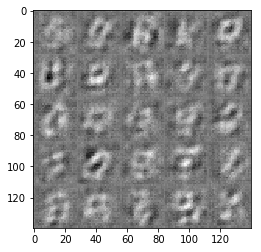

Epoch 1/2... Batch num 125/468... Discriminator Loss: 1.0656... Generator Loss: 0.7642
Epoch 1/2... Batch num 150/468... Discriminator Loss: 0.8759... Generator Loss: 1.3547
Epoch 1/2... Batch num 175/468... Discriminator Loss: 1.0201... Generator Loss: 0.6760
Epoch 1/2... Batch num 200/468... Discriminator Loss: 0.8967... Generator Loss: 1.3765


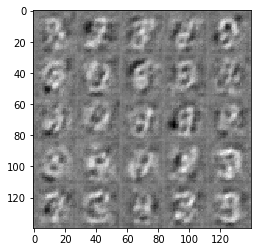

Epoch 1/2... Batch num 225/468... Discriminator Loss: 1.0071... Generator Loss: 1.7989
Epoch 1/2... Batch num 250/468... Discriminator Loss: 0.8791... Generator Loss: 0.8405
Epoch 1/2... Batch num 275/468... Discriminator Loss: 0.8282... Generator Loss: 1.6815
Epoch 1/2... Batch num 300/468... Discriminator Loss: 0.7037... Generator Loss: 1.4443


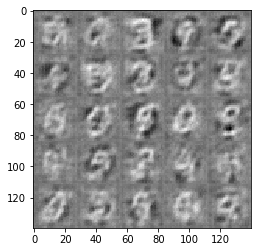

Epoch 1/2... Batch num 325/468... Discriminator Loss: 0.7340... Generator Loss: 2.0104
Epoch 1/2... Batch num 350/468... Discriminator Loss: 0.9084... Generator Loss: 0.6584
Epoch 1/2... Batch num 375/468... Discriminator Loss: 0.8239... Generator Loss: 0.8033
Epoch 1/2... Batch num 400/468... Discriminator Loss: 1.0798... Generator Loss: 2.9381


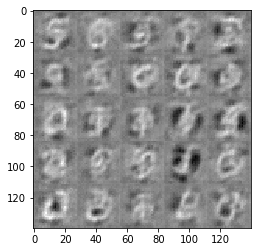

Epoch 1/2... Batch num 425/468... Discriminator Loss: 0.9457... Generator Loss: 0.7253
Epoch 1/2... Batch num 450/468... Discriminator Loss: 0.7204... Generator Loss: 1.2798
Epoch 2/2... Batch num 475/468... Discriminator Loss: 0.8183... Generator Loss: 0.8651
Epoch 2/2... Batch num 500/468... Discriminator Loss: 1.1975... Generator Loss: 2.3674


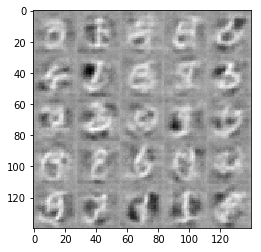

Epoch 2/2... Batch num 525/468... Discriminator Loss: 0.7303... Generator Loss: 1.2707
Epoch 2/2... Batch num 550/468... Discriminator Loss: 0.9558... Generator Loss: 0.7306
Epoch 2/2... Batch num 575/468... Discriminator Loss: 1.4820... Generator Loss: 2.6907
Epoch 2/2... Batch num 600/468... Discriminator Loss: 0.8393... Generator Loss: 0.9895


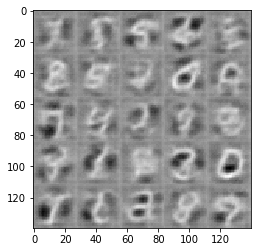

Epoch 2/2... Batch num 625/468... Discriminator Loss: 0.7997... Generator Loss: 1.0966
Epoch 2/2... Batch num 650/468... Discriminator Loss: 1.0615... Generator Loss: 0.6341
Epoch 2/2... Batch num 675/468... Discriminator Loss: 0.8845... Generator Loss: 0.9631
Epoch 2/2... Batch num 700/468... Discriminator Loss: 0.7186... Generator Loss: 1.0969


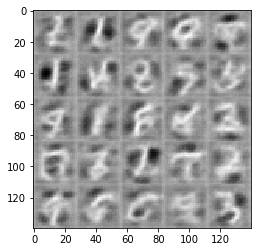

Epoch 2/2... Batch num 725/468... Discriminator Loss: 0.9053... Generator Loss: 1.5564
Epoch 2/2... Batch num 750/468... Discriminator Loss: 0.8472... Generator Loss: 1.3777
Epoch 2/2... Batch num 775/468... Discriminator Loss: 0.8306... Generator Loss: 1.2473
Epoch 2/2... Batch num 800/468... Discriminator Loss: 1.0981... Generator Loss: 0.5607


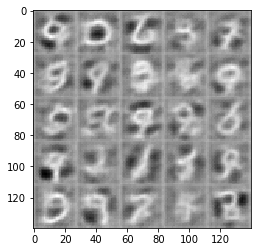

Epoch 2/2... Batch num 825/468... Discriminator Loss: 1.1984... Generator Loss: 0.5105
Epoch 2/2... Batch num 850/468... Discriminator Loss: 0.8390... Generator Loss: 1.5043
Epoch 2/2... Batch num 875/468... Discriminator Loss: 0.8130... Generator Loss: 0.8861
Epoch 2/2... Batch num 900/468... Discriminator Loss: 0.9205... Generator Loss: 0.7296


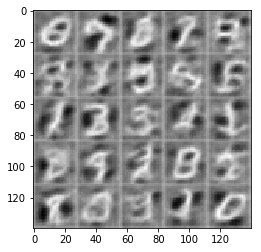

Epoch 2/2... Batch num 925/468... Discriminator Loss: 0.7442... Generator Loss: 0.9427


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

image_width: 28 image_height: 28 image_channels: 3 data_num: 202599 batch_num:  3165
Epoch 1/1... Batch num 25/3165... Discriminator Loss: 1.3684... Generator Loss: 0.4928
Epoch 1/1... Batch num 50/3165... Discriminator Loss: 0.9308... Generator Loss: 0.7958
Epoch 1/1... Batch num 75/3165... Discriminator Loss: 1.6366... Generator Loss: 5.3080
Epoch 1/1... Batch num 100/3165... Discriminator Loss: 0.5755... Generator Loss: 1.6982


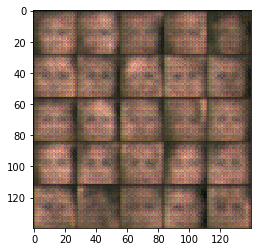

Epoch 1/1... Batch num 125/3165... Discriminator Loss: 0.7047... Generator Loss: 1.1016
Epoch 1/1... Batch num 150/3165... Discriminator Loss: 1.5628... Generator Loss: 1.7712
Epoch 1/1... Batch num 175/3165... Discriminator Loss: 2.2417... Generator Loss: 3.0888
Epoch 1/1... Batch num 200/3165... Discriminator Loss: 1.4892... Generator Loss: 0.5292


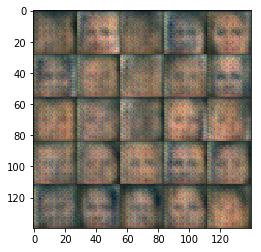

Epoch 1/1... Batch num 225/3165... Discriminator Loss: 1.1284... Generator Loss: 1.0126
Epoch 1/1... Batch num 250/3165... Discriminator Loss: 0.7674... Generator Loss: 2.0236
Epoch 1/1... Batch num 275/3165... Discriminator Loss: 0.6861... Generator Loss: 1.5213
Epoch 1/1... Batch num 300/3165... Discriminator Loss: 1.5411... Generator Loss: 2.9780


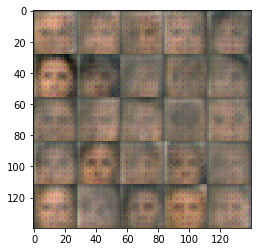

Epoch 1/1... Batch num 325/3165... Discriminator Loss: 0.9512... Generator Loss: 1.3533
Epoch 1/1... Batch num 350/3165... Discriminator Loss: 2.0222... Generator Loss: 0.2122
Epoch 1/1... Batch num 375/3165... Discriminator Loss: 0.6189... Generator Loss: 1.5420
Epoch 1/1... Batch num 400/3165... Discriminator Loss: 1.1496... Generator Loss: 0.7026


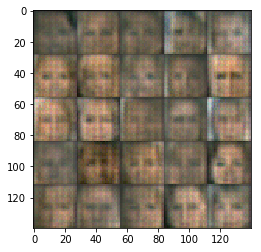

Epoch 1/1... Batch num 425/3165... Discriminator Loss: 1.1270... Generator Loss: 0.8555
Epoch 1/1... Batch num 450/3165... Discriminator Loss: 1.4620... Generator Loss: 1.2896
Epoch 1/1... Batch num 475/3165... Discriminator Loss: 1.1760... Generator Loss: 0.5553
Epoch 1/1... Batch num 500/3165... Discriminator Loss: 1.7672... Generator Loss: 0.2444


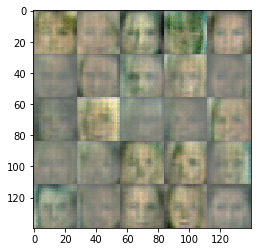

Epoch 1/1... Batch num 525/3165... Discriminator Loss: 0.4782... Generator Loss: 2.0718
Epoch 1/1... Batch num 550/3165... Discriminator Loss: 0.6554... Generator Loss: 1.6559
Epoch 1/1... Batch num 575/3165... Discriminator Loss: 1.7666... Generator Loss: 0.3054
Epoch 1/1... Batch num 600/3165... Discriminator Loss: 0.9424... Generator Loss: 0.8919


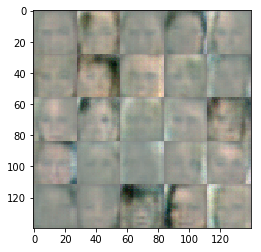

Epoch 1/1... Batch num 625/3165... Discriminator Loss: 2.3734... Generator Loss: 0.1267
Epoch 1/1... Batch num 650/3165... Discriminator Loss: 1.1755... Generator Loss: 0.6450
Epoch 1/1... Batch num 675/3165... Discriminator Loss: 0.9290... Generator Loss: 1.7415
Epoch 1/1... Batch num 700/3165... Discriminator Loss: 0.5220... Generator Loss: 2.5230


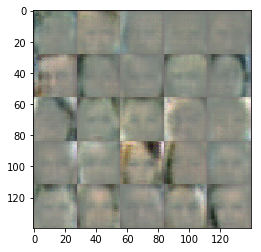

Epoch 1/1... Batch num 725/3165... Discriminator Loss: 0.8481... Generator Loss: 1.3667
Epoch 1/1... Batch num 750/3165... Discriminator Loss: 1.5376... Generator Loss: 0.3509
Epoch 1/1... Batch num 775/3165... Discriminator Loss: 0.9349... Generator Loss: 0.7099
Epoch 1/1... Batch num 800/3165... Discriminator Loss: 0.8050... Generator Loss: 1.1584


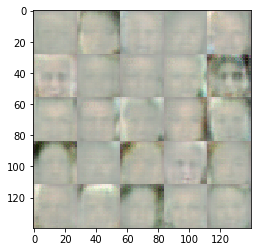

Epoch 1/1... Batch num 825/3165... Discriminator Loss: 1.0002... Generator Loss: 1.1174
Epoch 1/1... Batch num 850/3165... Discriminator Loss: 1.4245... Generator Loss: 1.7750
Epoch 1/1... Batch num 875/3165... Discriminator Loss: 1.1173... Generator Loss: 0.5921
Epoch 1/1... Batch num 900/3165... Discriminator Loss: 1.1619... Generator Loss: 0.9178


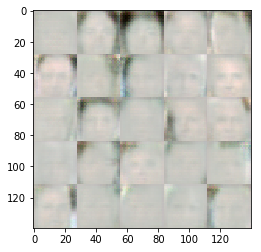

Epoch 1/1... Batch num 925/3165... Discriminator Loss: 1.2270... Generator Loss: 0.6970
Epoch 1/1... Batch num 950/3165... Discriminator Loss: 0.5546... Generator Loss: 1.6346
Epoch 1/1... Batch num 975/3165... Discriminator Loss: 1.4348... Generator Loss: 0.4094
Epoch 1/1... Batch num 1000/3165... Discriminator Loss: 1.0588... Generator Loss: 0.6238


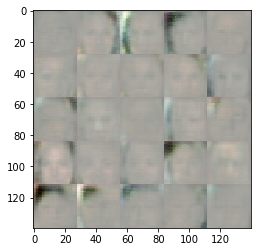

Epoch 1/1... Batch num 1025/3165... Discriminator Loss: 3.2070... Generator Loss: 3.3350
Epoch 1/1... Batch num 1050/3165... Discriminator Loss: 0.4600... Generator Loss: 1.7251
Epoch 1/1... Batch num 1075/3165... Discriminator Loss: 1.4550... Generator Loss: 0.3550
Epoch 1/1... Batch num 1100/3165... Discriminator Loss: 0.9761... Generator Loss: 2.4438


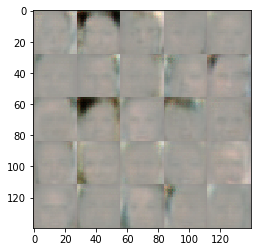

Epoch 1/1... Batch num 1125/3165... Discriminator Loss: 0.4840... Generator Loss: 1.9474
Epoch 1/1... Batch num 1150/3165... Discriminator Loss: 1.0188... Generator Loss: 0.6202
Epoch 1/1... Batch num 1175/3165... Discriminator Loss: 0.7196... Generator Loss: 2.2979
Epoch 1/1... Batch num 1200/3165... Discriminator Loss: 1.0484... Generator Loss: 0.8044


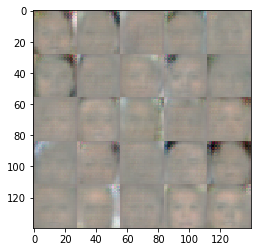

Epoch 1/1... Batch num 1225/3165... Discriminator Loss: 1.1260... Generator Loss: 1.4148
Epoch 1/1... Batch num 1250/3165... Discriminator Loss: 1.1006... Generator Loss: 2.1366
Epoch 1/1... Batch num 1275/3165... Discriminator Loss: 0.3384... Generator Loss: 3.2095
Epoch 1/1... Batch num 1300/3165... Discriminator Loss: 1.5904... Generator Loss: 0.3271


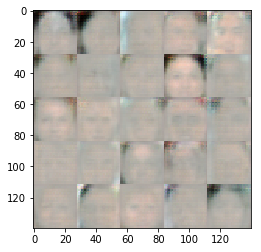

Epoch 1/1... Batch num 1325/3165... Discriminator Loss: 0.7833... Generator Loss: 1.2296
Epoch 1/1... Batch num 1350/3165... Discriminator Loss: 0.7260... Generator Loss: 1.4642
Epoch 1/1... Batch num 1375/3165... Discriminator Loss: 0.9416... Generator Loss: 2.1468
Epoch 1/1... Batch num 1400/3165... Discriminator Loss: 1.1042... Generator Loss: 0.6044


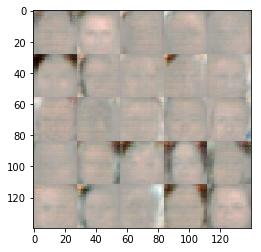

Epoch 1/1... Batch num 1425/3165... Discriminator Loss: 0.6211... Generator Loss: 1.2362
Epoch 1/1... Batch num 1450/3165... Discriminator Loss: 0.8946... Generator Loss: 2.2014
Epoch 1/1... Batch num 1475/3165... Discriminator Loss: 1.3765... Generator Loss: 0.4355
Epoch 1/1... Batch num 1500/3165... Discriminator Loss: 1.7780... Generator Loss: 0.2643


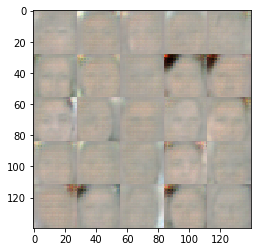

Epoch 1/1... Batch num 1525/3165... Discriminator Loss: 0.9048... Generator Loss: 1.8207
Epoch 1/1... Batch num 1550/3165... Discriminator Loss: 1.1104... Generator Loss: 0.6191
Epoch 1/1... Batch num 1575/3165... Discriminator Loss: 1.6692... Generator Loss: 0.3003
Epoch 1/1... Batch num 1600/3165... Discriminator Loss: 0.5582... Generator Loss: 1.5705


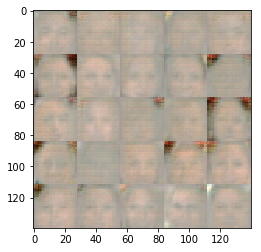

Epoch 1/1... Batch num 1625/3165... Discriminator Loss: 0.8812... Generator Loss: 0.8166
Epoch 1/1... Batch num 1650/3165... Discriminator Loss: 1.0582... Generator Loss: 0.6438
Epoch 1/1... Batch num 1675/3165... Discriminator Loss: 2.2380... Generator Loss: 0.2117
Epoch 1/1... Batch num 1700/3165... Discriminator Loss: 1.1243... Generator Loss: 0.6031


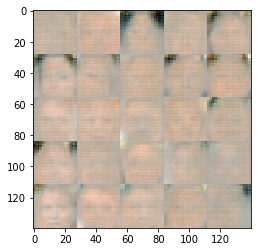

Epoch 1/1... Batch num 1725/3165... Discriminator Loss: 1.2318... Generator Loss: 1.6022
Epoch 1/1... Batch num 1750/3165... Discriminator Loss: 0.9839... Generator Loss: 0.8752
Epoch 1/1... Batch num 1775/3165... Discriminator Loss: 0.9479... Generator Loss: 0.8161
Epoch 1/1... Batch num 1800/3165... Discriminator Loss: 0.4930... Generator Loss: 2.6852


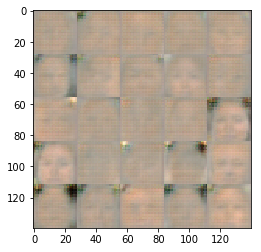

Epoch 1/1... Batch num 1825/3165... Discriminator Loss: 1.0895... Generator Loss: 0.5915
Epoch 1/1... Batch num 1850/3165... Discriminator Loss: 1.0022... Generator Loss: 0.7894
Epoch 1/1... Batch num 1875/3165... Discriminator Loss: 1.2037... Generator Loss: 0.5378
Epoch 1/1... Batch num 1900/3165... Discriminator Loss: 0.8490... Generator Loss: 1.1821


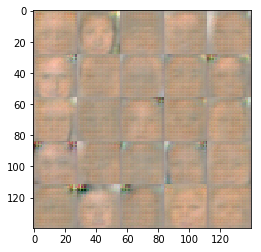

Epoch 1/1... Batch num 1925/3165... Discriminator Loss: 1.2461... Generator Loss: 0.4464
Epoch 1/1... Batch num 1950/3165... Discriminator Loss: 0.4660... Generator Loss: 2.2529
Epoch 1/1... Batch num 1975/3165... Discriminator Loss: 0.5883... Generator Loss: 1.6039
Epoch 1/1... Batch num 2000/3165... Discriminator Loss: 1.3058... Generator Loss: 0.4451


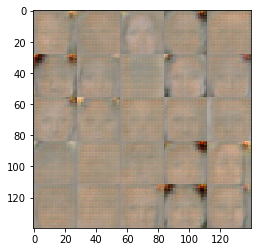

Epoch 1/1... Batch num 2025/3165... Discriminator Loss: 1.7506... Generator Loss: 0.2825
Epoch 1/1... Batch num 2050/3165... Discriminator Loss: 0.5782... Generator Loss: 1.8578
Epoch 1/1... Batch num 2075/3165... Discriminator Loss: 1.3834... Generator Loss: 0.4118
Epoch 1/1... Batch num 2100/3165... Discriminator Loss: 0.6357... Generator Loss: 1.4554


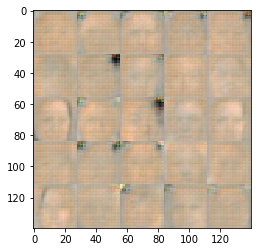

Epoch 1/1... Batch num 2125/3165... Discriminator Loss: 1.4840... Generator Loss: 0.3467
Epoch 1/1... Batch num 2150/3165... Discriminator Loss: 0.9248... Generator Loss: 2.1498
Epoch 1/1... Batch num 2175/3165... Discriminator Loss: 1.1735... Generator Loss: 0.6248
Epoch 1/1... Batch num 2200/3165... Discriminator Loss: 1.4539... Generator Loss: 2.0764


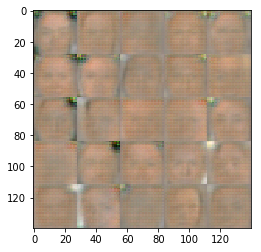

Epoch 1/1... Batch num 2225/3165... Discriminator Loss: 0.5876... Generator Loss: 1.8386
Epoch 1/1... Batch num 2250/3165... Discriminator Loss: 0.6814... Generator Loss: 1.1950
Epoch 1/1... Batch num 2275/3165... Discriminator Loss: 0.7642... Generator Loss: 1.8825
Epoch 1/1... Batch num 2300/3165... Discriminator Loss: 1.3064... Generator Loss: 0.4136


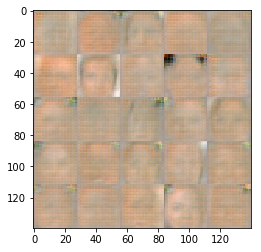

Epoch 1/1... Batch num 2325/3165... Discriminator Loss: 0.5940... Generator Loss: 1.6882
Epoch 1/1... Batch num 2350/3165... Discriminator Loss: 1.4010... Generator Loss: 0.4044
Epoch 1/1... Batch num 2375/3165... Discriminator Loss: 0.6547... Generator Loss: 1.1279
Epoch 1/1... Batch num 2400/3165... Discriminator Loss: 1.5063... Generator Loss: 0.3224


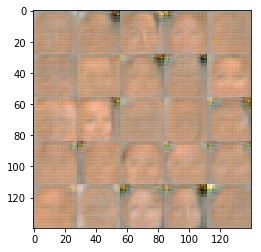

Epoch 1/1... Batch num 2425/3165... Discriminator Loss: 1.3945... Generator Loss: 1.5177
Epoch 1/1... Batch num 2450/3165... Discriminator Loss: 0.9833... Generator Loss: 2.1496
Epoch 1/1... Batch num 2475/3165... Discriminator Loss: 1.4751... Generator Loss: 0.3363
Epoch 1/1... Batch num 2500/3165... Discriminator Loss: 0.9077... Generator Loss: 0.7552


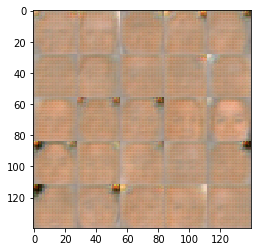

Epoch 1/1... Batch num 2525/3165... Discriminator Loss: 1.3707... Generator Loss: 0.4040
Epoch 1/1... Batch num 2550/3165... Discriminator Loss: 1.2412... Generator Loss: 0.5275
Epoch 1/1... Batch num 2575/3165... Discriminator Loss: 1.3140... Generator Loss: 1.6115
Epoch 1/1... Batch num 2600/3165... Discriminator Loss: 0.9212... Generator Loss: 0.7213


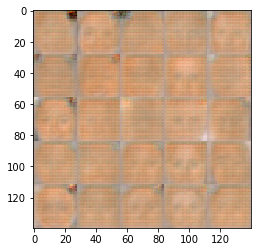

Epoch 1/1... Batch num 2625/3165... Discriminator Loss: 0.7842... Generator Loss: 1.9676
Epoch 1/1... Batch num 2650/3165... Discriminator Loss: 0.8381... Generator Loss: 0.7625
Epoch 1/1... Batch num 2675/3165... Discriminator Loss: 1.0900... Generator Loss: 0.6114
Epoch 1/1... Batch num 2700/3165... Discriminator Loss: 0.8180... Generator Loss: 1.7824


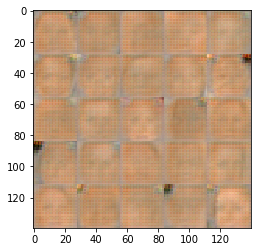

Epoch 1/1... Batch num 2725/3165... Discriminator Loss: 1.0449... Generator Loss: 1.8803
Epoch 1/1... Batch num 2750/3165... Discriminator Loss: 0.8048... Generator Loss: 1.0731
Epoch 1/1... Batch num 2775/3165... Discriminator Loss: 0.9570... Generator Loss: 0.7600
Epoch 1/1... Batch num 2800/3165... Discriminator Loss: 0.9240... Generator Loss: 1.0117


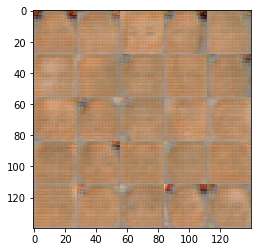

Epoch 1/1... Batch num 2825/3165... Discriminator Loss: 1.2533... Generator Loss: 1.6661
Epoch 1/1... Batch num 2850/3165... Discriminator Loss: 0.8381... Generator Loss: 1.2619
Epoch 1/1... Batch num 2875/3165... Discriminator Loss: 0.8833... Generator Loss: 1.3634
Epoch 1/1... Batch num 2900/3165... Discriminator Loss: 0.8238... Generator Loss: 0.8873


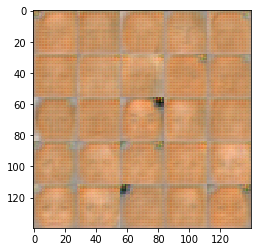

Epoch 1/1... Batch num 2925/3165... Discriminator Loss: 1.0976... Generator Loss: 1.4567
Epoch 1/1... Batch num 2950/3165... Discriminator Loss: 1.3349... Generator Loss: 0.4735
Epoch 1/1... Batch num 2975/3165... Discriminator Loss: 1.3871... Generator Loss: 0.3810
Epoch 1/1... Batch num 3000/3165... Discriminator Loss: 1.0116... Generator Loss: 1.4542


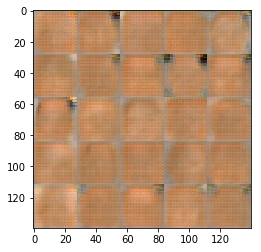

Epoch 1/1... Batch num 3025/3165... Discriminator Loss: 1.5281... Generator Loss: 0.3255
Epoch 1/1... Batch num 3050/3165... Discriminator Loss: 0.7000... Generator Loss: 1.0948
Epoch 1/1... Batch num 3075/3165... Discriminator Loss: 0.9989... Generator Loss: 1.2806
Epoch 1/1... Batch num 3100/3165... Discriminator Loss: 0.8112... Generator Loss: 1.4168


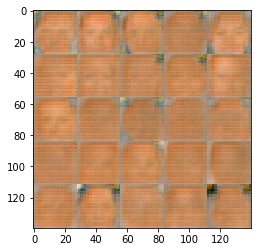

Epoch 1/1... Batch num 3125/3165... Discriminator Loss: 0.7969... Generator Loss: 0.9479
Epoch 1/1... Batch num 3150/3165... Discriminator Loss: 0.8106... Generator Loss: 1.5723


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.